# Analysis of user behaviour and outcome prediction for E-Learning course

## Problem 1. Identify e-learning steps causing undesirable course drop-out

## Problem 2. Create a predictor to identify whether user will drop-out or finish the course using behavioural data from first 3 days of study


# Loading libraries and datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [111]:
# loading EVENT dataset
events_data = pd.read_csv('event_data_train.csv.zip', compression='zip')


# adding new columns (date /day)
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15
...,...,...,...,...,...,...
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19


In [5]:
# loading SUBMISSIONS dataset
submissions_data = pd.read_csv('submissions_data_train.csv')

# adding new columns (date /day)
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15
...,...,...,...,...,...,...
509099,120745,1501946959,wrong,2615,2017-08-05 15:29:19,2017-08-05
509100,120745,1503059927,correct,13177,2017-08-18 12:38:47,2017-08-18
509101,120745,1506348153,wrong,15253,2017-09-25 14:02:33,2017-09-25
509102,120745,1523035316,wrong,1424,2018-04-06 17:21:56,2018-04-06


# Preparation of user data

In [6]:
# count correct submission for every user 
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

users_scores

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1
...,...,...,...
9935,26787,3,0
9936,26790,1,0
9937,26794,33,9
9938,26797,2,0


In [7]:
# calculate last event for every user
users_data = events_data.groupby('user_id', as_index=False)\
                        .agg({'timestamp': 'max'})\
                        .rename(columns={'timestamp': 'last_timestamp'})
users_data

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660
...,...,...
19229,26790,1517495987
19230,26793,1510225034
19231,26794,1512035039
19232,26797,1509995096


In [8]:
# is this user gone or not?
NOW = 1526772811  # last timestamp for all data
DROP_OUT_DAYS = 30
drop_out_treshold = DROP_OUT_DAYS * 24 * 60 * 60 # пороговое значение
users_data['is_gone_user'] = (NOW - users_data.last_timestamp) > drop_out_treshold
users_data

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
...,...,...,...
19229,26790,1517495987,True
19230,26793,1510225034,True
19231,26794,1512035039,True
19232,26797,1509995096,True


In [9]:
# adding submissions for every users
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [10]:
# making pivot table for user events
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [11]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [12]:
# whether user has passed more than 175 steps? 
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_data = users_data.merge(users_days, how='outer')

users_data['passed_course'] = users_data.passed > 175
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [13]:
# data check
users_data.user_id.nunique()

19234

In [14]:
events_data.user_id.nunique()

19234

In [15]:
users_data[users_data.passed_course].day.median()

21.0

# Problem 1: Identification of steps cousing course drop-out

In [16]:
# searching for problematic steps causing drop-out
# problematic step: "last_submission" == 'wrong' & "user is gone" == True & "passed_course" == 'False'

last_data = submissions_data.merge(submissions_data\
                            .groupby('user_id')\
                            .agg({'timestamp':'max'})\
                            .rename(columns={'timestamp': 'last_timestamp'}),
                             how='outer', on='user_id')

last_data = last_data[(last_data.submission_status == 'wrong') \
                    & (last_data.timestamp == last_data.last_timestamp)]\
                    .groupby('step_id')\
                    .count()\
                    .sort_values(by='timestamp', ascending=False)

In [17]:
#problematic steps (sorted on numbers of dropped users)
last_data

,timestamp,submission_status,user_id,date,day,last_timestamp
step_id,,,,,,
31978,154,154,154,154,154,154
32812,133,133,133,133,133,133
32031,97,97,97,97,97,97
32202,92,92,92,92,92,92
33481,78,78,78,78,78,78
...,...,...,...,...,...,...
33482,1,1,1,1,1,1
33686,1,1,1,1,1,1
33684,1,1,1,1,1,1


In [18]:
# searching for problematic steps causing drop-out (variant 2)
submissions_data.sort_values(by='timestamp')\
                .groupby('user_id').last()\
                .query("submission_status == 'wrong'")\
                .step_id.value_counts()

31978    154
32812    133
32031     97
32202     92
33481     78
        ... 
33684      1
33686      1
31988      1
32929      1
33482      1
Name: step_id, Length: 72, dtype: int64

In [19]:
# loading visualisation libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

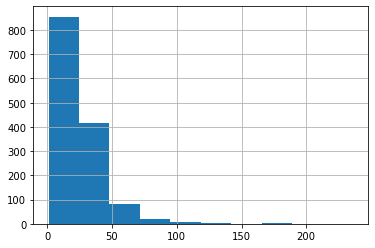

In [20]:
# total lenght of course for successful users
users_data[users_data.passed_course].day.hist()

# Problem 2. Prediction of users behaviour (course drop-out) using the data from first 3 days

**Selecting of events and sumbissions for first 3 days**

In [21]:
# calculation starting time for every user
user_min_time = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'min'}) \
    .rename({'timestamp': 'min_timestamp'}, axis=1)
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [22]:
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [23]:
# set threshold time (days for training)
THRESHOLD_DAYS = 3
learning_time_threshold = THRESHOLD_DAYS * 24 * 60 * 60    # threshold in seconds
learning_time_threshold

259200

In [24]:
# calculating threshold time for every user
users_data['user_learning_time_threshold'] =\
                     users_data['min_timestamp'] + learning_time_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp,user_learning_time_threshold
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,1473086664
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,1514642564
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,1434617676
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809,1466416009
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660,1521893860


In [25]:
# copy threshold data from "users_data" to "events_data"
events_data = events_data.merge(users_data\
                    [['user_id', 'user_learning_time_threshold']], how='outer')
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048


In [26]:
events_data.shape

(3480703, 7)

In [27]:
# selecting events before threshold
events_data_train = events_data\
         [events_data.timestamp <= events_data.user_learning_time_threshold]
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048


In [28]:
events_data_train.shape

(1014985, 7)

In [29]:
# check numbers of calendar days for model training in Events
events_data_train.groupby('user_id').day.nunique().max()

4

In [30]:
# selecting submissions before threshold
submissions_data = submissions_data.merge(users_data[['user_id', 'user_learning_time_threshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.timestamp <= submissions_data.user_learning_time_threshold]
submissions_data_train

,step_id,timestamp,submission_status,user_id,date,day,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434605177
...,...,...,...,...,...,...,...
509099,120745.0,1.501947e+09,wrong,2615,2017-08-05 15:29:19,2017-08-05,1502205860
509100,120745.0,1.503060e+09,correct,13177,2017-08-18 12:38:47,2017-08-18,1503314487
509101,120745.0,1.506348e+09,wrong,15253,2017-09-25 14:02:33,2017-09-25,1506606463
509102,120745.0,1.523035e+09,wrong,1424,2018-04-06 17:21:56,2018-04-06,1523294469


In [31]:
# check numbers of calendar days for model training in Submissions
submissions_data_train.groupby('user_id').day.nunique().max()

4

**Creating dataset for model training**

In [32]:
# creating training dataset
X = submissions_data_train.groupby('user_id').day.nunique(). \
    to_frame().reset_index().rename(columns=({
        'day': 'days'
}))
X

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3
...,...,...
8908,26787,1
8909,26790,1
8910,26794,3
8911,26797,1


In [33]:
# add numbers of tried steps during first 3 days
steps_tried = submissions_data_train.groupby('user_id').step_id \
    .nunique().to_frame().reset_index().rename(columns={
        'step_id': 'steps_tried'
})
X = X.merge(steps_tried, on='user_id', how='outer')
X

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,3,23
...,...,...,...
8908,26787,1,3
8909,26790,1,1
8910,26794,3,27
8911,26797,1,2


In [34]:
# add number of correct and wrong submissions
X = X.merge(submissions_data_train.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index())
X

,user_id,days,steps_tried,correct,wrong
0,2,1,2,2,0
1,3,1,4,4,4
2,8,1,11,9,21
3,14,1,1,0,1
4,16,3,23,23,27
...,...,...,...,...,...
8908,26787,1,3,3,0
8909,26790,1,1,1,0
8910,26794,3,27,31,9
8911,26797,1,2,2,0


In [35]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [36]:
# add number of viewed steps
X = X.merge(events_data_train.pivot_table(index='user_id',
                        columns='action',
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...,...
19229,26774,NaN,NaN,NaN,NaN,NaN,1
19230,26781,NaN,NaN,NaN,NaN,NaN,6
19231,26788,NaN,NaN,NaN,NaN,NaN,1
19232,26789,NaN,NaN,NaN,NaN,NaN,2


In [37]:
X = X.fillna(0)

In [38]:
# add additional data for easy mark-up
X = X.merge(users_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [39]:
# filtering users
X= X[(X.is_gone_user == True) | (X.passed_course == True)]
X

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True
...,...,...,...,...,...,...,...,...,...
19229,26774,0.0,0.0,0.0,0.0,0.00,1,False,True
19230,26781,0.0,0.0,0.0,0.0,0.00,6,True,True
19231,26788,0.0,0.0,0.0,0.0,0.00,1,False,True
19232,26789,0.0,0.0,0.0,0.0,0.00,2,False,True


In [40]:
# counting users
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16590
True           False             136
               True             1254
Name: user_id, dtype: int64

In [41]:
# creating target for model training
y = X.passed_course.map(int)
y

0        0
1        0
2        0
3        0
4        1
        ..
19229    0
19230    1
19231    0
19232    0
19233    0
Name: passed_course, Length: 17980, dtype: int64

In [42]:
# cleaning of training features
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)
X

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
...,...,...,...,...,...,...
26774,0.0,0.0,0.0,0.0,0.00,1
26781,0.0,0.0,0.0,0.0,0.00,6
26788,0.0,0.0,0.0,0.0,0.00,1


In [43]:
# splitting the data for training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [44]:
X_train

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
19929,3.0,12.0,12.0,3.0,0.800000,40
7321,0.0,0.0,0.0,0.0,0.000000,3
1851,2.0,6.0,6.0,2.0,0.750000,51
13315,0.0,0.0,0.0,0.0,0.000000,2
1761,2.0,9.0,9.0,28.0,0.243243,69
...,...,...,...,...,...,...
13850,2.0,16.0,16.0,83.0,0.161616,117
24930,3.0,12.0,12.0,17.0,0.413793,106
23608,0.0,0.0,0.0,0.0,0.000000,1


In [45]:
X_test

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
5918,1.0,2.0,1.0,5.0,0.166667,12
17708,0.0,0.0,0.0,0.0,0.000000,1
5134,3.0,34.0,34.0,4.0,0.894737,132
22127,0.0,0.0,0.0,0.0,0.000000,2
4020,0.0,0.0,0.0,0.0,0.000000,1
...,...,...,...,...,...,...
1186,1.0,2.0,2.0,0.0,1.000000,16
2731,1.0,1.0,0.0,1.0,0.000000,10
24332,1.0,1.0,1.0,0.0,1.000000,4


In [46]:
y_train

6625     1
11707    0
664      0
14041    1
638      0
        ..
4647     1
8286     1
18014    0
9455     0
11004    0
Name: passed_course, Length: 13485, dtype: int64

In [53]:
y_test

2002     0
15740    0
1759     0
17446    0
10450    0
        ..
448      0
956      0
8102     0
5156     0
5950     0
Name: passed_course, Length: 4495, dtype: int64

## Selection of Predictor model

### Decision Tree

In [54]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion='entropy')

In [55]:
# hyperparameters optimisation (randomized)
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth' : range(1,8), 'min_samples_leaf': range(50, 1000, 50), 'min_samples_split': range(50, 1000, 50)}
search_random = RandomizedSearchCV(dtc, params, cv = 5)
search_random.fit(X_train, y_train)
best_tree_random = search_random.best_estimator_
best_tree_random

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=50,
                       min_samples_split=700)

In [56]:
best_tree_random.score(X_train, y_train)

0.9245087133852429

In [57]:
best_tree_random.score(X_test, y_test)

0.9276974416017798

In [58]:
# hyperparameters optimisation (GridSearch)
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : range(1,5), 'min_samples_leaf': range(50, 1000, 50), 'min_samples_split': range(50, 1000, 50)}
search_grid = GridSearchCV(dtc, params, cv = 5)
search_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': range(1, 5),
                         'min_samples_leaf': range(50, 1000, 50),
                         'min_samples_split': range(50, 1000, 50)})

In [59]:
best_tree = search_grid.best_estimator_
best_tree

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=100,
                       min_samples_split=50)

In [60]:
best_tree.score(X_train, y_train)

0.9245087133852429

In [61]:
best_tree.score(X_test, y_test)

0.9276974416017798

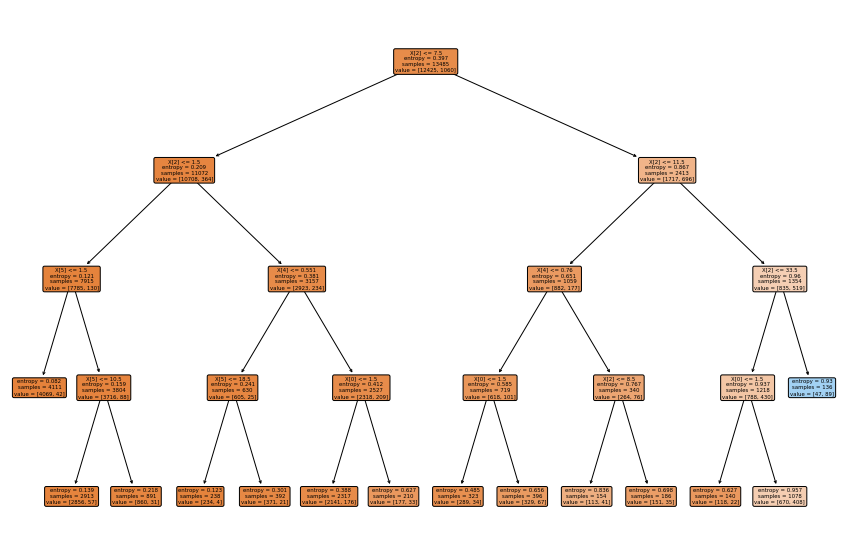

In [62]:
# tree visualisation
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize = (15, 10))
plot_tree(best_tree, filled=True, rounded=True) 
plt.show()


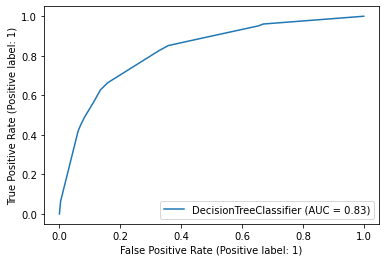

In [74]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(estimator=best_tree, X= X_test, y= y_test)

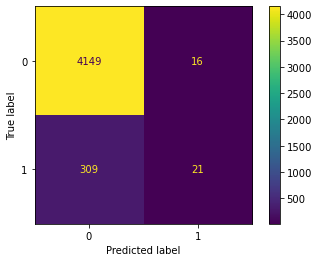

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_tree, X_test, y_test)

### Random Forest model

In [76]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()

In [77]:
# Random Forest optimisation
params = {'n_estimators': [10, 20, 30], 'max_depth': [2, 5, 7, 10]}
from sklearn.model_selection import GridSearchCV
grid_search_cv_clf = GridSearchCV(clf_rf, params, cv=5, verbose=True, n_jobs=-1)
grid_search_cv_clf.fit(X_train, y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 7, 10],
                         'n_estimators': [10, 20, 30]},
             verbose=True)

In [78]:
best_forest = grid_search_cv_clf.best_estimator_
best_forest

RandomForestClassifier(max_depth=5, n_estimators=10)

In [79]:
best_forest.score(X_train, y_train)

0.9265850945494994

In [80]:
best_forest.score(X_test, y_test)

0.9281423804226919

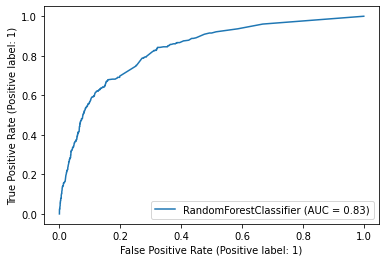

In [81]:
RocCurveDisplay.from_estimator(best_forest, X_test, y_test)

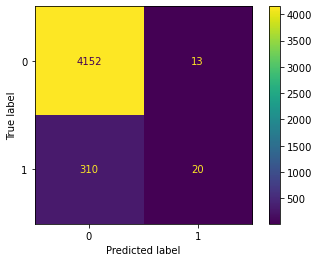

In [82]:
ConfusionMatrixDisplay.from_estimator(best_forest, X_test, y_test)

<AxesSubplot:>

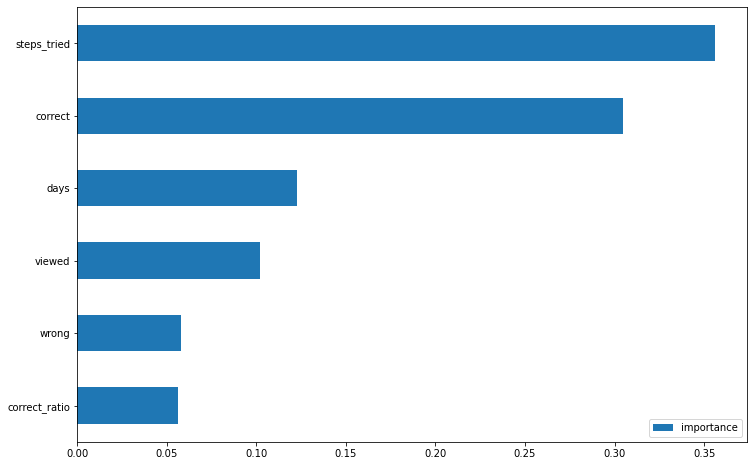

In [83]:
importances = pd.DataFrame(best_forest.feature_importances_, index=X.columns, columns=['importance'])
importances.sort_values('importance').plot(kind='barh', figsize=(12, 8))

### KNeighbors Model

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [85]:
knn.score(X_test, y_test)

0.9174638487208009

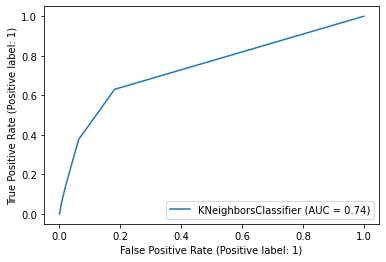

In [87]:
RocCurveDisplay.from_estimator(knn, X_test, y_test)

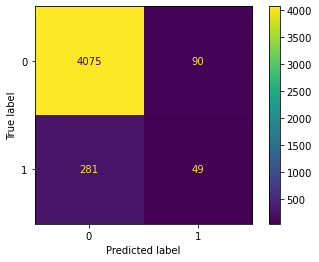

In [88]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)

### Logistic Regression model

In [89]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=5)
lr.fit(X_train, y_train)

LogisticRegressionCV(cv=5)

In [90]:
lr.score(X_test, y_test)

0.9259176863181312

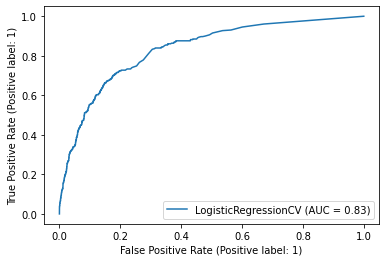

In [91]:
RocCurveDisplay.from_estimator(lr, X_test, y_test)

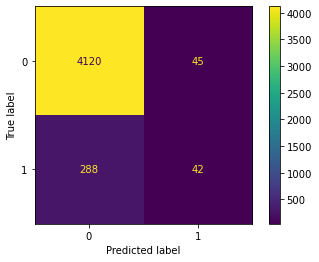

In [92]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

### SVC model

In [93]:
from sklearn.svm import SVC
svc = SVC(gamma='scale')
svc.fit(X_train, y_train)


SVC()

In [94]:
svc.score(X_test, y_test)

0.9268075639599556

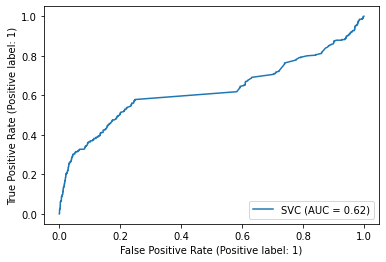

In [97]:
RocCurveDisplay.from_estimator(svc, X_test, y_test)

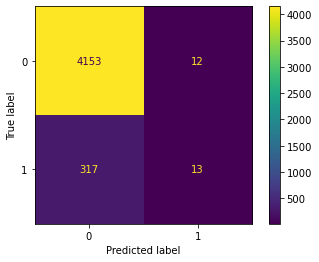

In [96]:
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test)

### Gaussian Naive Bayes model

In [98]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [99]:
gnb.score(X_test, y_test)

0.8843159065628476

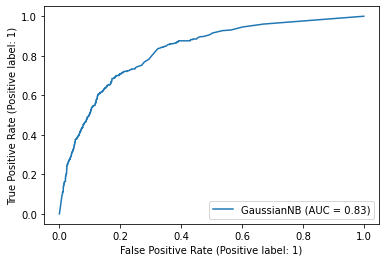

In [100]:
RocCurveDisplay.from_estimator(gnb, X_test, y_test)

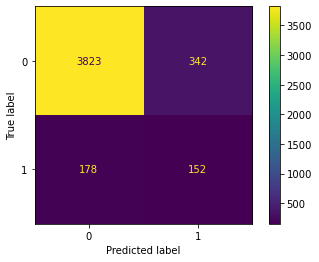

In [101]:
ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test)

## Evaluation of the models: Classification reports and Cross-Validation

In [102]:
# list of used classification models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
estimators = {
     'KNeighborsClassifier': knn, 
     'SVC': svc,
     'GaussianNB':gnb,
     'DecisionTree': best_tree,
     'RandomForest': best_forest,
     'LogisticRegression': lr
          }

In [103]:
# printing classification reports
from sklearn.metrics import classification_report, roc_auc_score
for estimator_name, estimator_object in estimators.items():
    print(estimator_name)
    print(f'ROC AUC score: {roc_auc_score(y_test, estimator_object.predict(X_test)):.2%}')
    print(classification_report(y_test, estimator_object.predict(X_test)))
    print()
    print()

KNeighborsClassifier
ROC AUC score: 56.34%
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4165
           1       0.35      0.15      0.21       330

    accuracy                           0.92      4495
   macro avg       0.64      0.56      0.58      4495
weighted avg       0.89      0.92      0.90      4495



SVC
ROC AUC score: 51.83%
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4165
           1       0.52      0.04      0.07       330

    accuracy                           0.93      4495
   macro avg       0.72      0.52      0.52      4495
weighted avg       0.90      0.93      0.90      4495



GaussianNB
ROC AUC score: 68.92%
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4165
           1       0.31      0.46      0.37       330

    accuracy                           0.88      4495
   macro avg       0.6

In [105]:
# evaluation on Cross_val_score
for estimator_name, estimator_object in estimators.items():
    kfold = KFold(n_splits=10, random_state=11, shuffle=True)
    scores = cross_val_score(estimator=estimator_object, 
         X=X, y=y, cv=kfold)
    print(f'{estimator_name:>20}: ' + 
           f'mean accuracy={scores.mean():.2%}; ' +
           f'standard deviation={scores.std():.2%}')

KNeighborsClassifier: mean accuracy=91.51%; standard deviation=0.63%
                 SVC: mean accuracy=92.42%; standard deviation=0.47%
          GaussianNB: mean accuracy=89.03%; standard deviation=0.73%
        DecisionTree: mean accuracy=92.45%; standard deviation=0.45%
        RandomForest: mean accuracy=92.46%; standard deviation=0.52%
  LogisticRegression: mean accuracy=92.37%; standard deviation=0.60%
